In [1]:
elastic_rods_dir = '../../../../elastic_rods/python/'
weaving_dir = '../../../'
import os
import os.path as osp
import sys; sys.path.append(elastic_rods_dir); sys.path.append(weaving_dir)
import numpy as np, elastic_rods, linkage_vis
import numpy.linalg as la
from bending_validation import suppress_stdout as so
import matplotlib.pyplot as plt
from elastic_rods import EnergyType, InterleavingType

# weaving
import analysis_helper, ribbon_linkage_helper, mesh_vis, linkage_utils, compute_curve_from_curvature, pipeline_helper, importlib
importlib.reload(analysis_helper)
importlib.reload(ribbon_linkage_helper)
importlib.reload(mesh_vis)
importlib.reload(linkage_utils)
importlib.reload(compute_curve_from_curvature)
importlib.reload(pipeline_helper)
from analysis_helper import (compare_turning_angle,
                            is_on_sphere, 
                            get_distance_to_center_scalar_field, 
                            plot_curvatures, 
                            get_curvature_scalar_field,
                            construct_elastic_rod_loop_from_rod_segments, 
                            concatenate_rod_properties_from_rod_segments, 
                            compute_min_distance_rigid_transformation)
from ribbon_linkage_helper import (update_rest_curvature, 
                                   set_ribbon_linkage,
                                   export_linkage_geometry_to_obj,
                                   write_linkage_ribbon_output_florin)

from compute_curve_from_curvature import (match_geo_curvature_and_edge_len, get_all_curve_pattern)
from linkage_utils import order_segments_by_ribbons, get_turning_angle_and_length_from_ordered_rods

from pipeline_helper import (initialize_linkage, get_normal_deviation, set_joint_vector_field, stage_1_optimization, initialize_stage_2_optimizer, stage_2_optimization, InputOrganizer, write_all_output, set_surface_view_options, get_structure_analysis_view, contact_optimization, get_double_side_view, show_selected_joints, highlight_rod_and_joint)
import vis.fields
import matplotlib.cm as cm
import time

In [2]:
import parallelism
parallelism.set_max_num_tbb_threads(24)
parallelism.set_hessian_assembly_num_threads(8)
parallelism.set_gradient_assembly_num_threads(8)

In [3]:
rod_length = 0.09982061776030171
width = rod_length / 15 * 5
thickness = width / 5 * 0.35
print(width, thickness)
io = InputOrganizer('new_kitty_1', thickness, width, weaving_dir)
#  [ ear 214, ear 255, nose 39]

0.033273539253433904 0.0023291477477403733


In [4]:
import py_newton_optimizer
OPTS = py_newton_optimizer.NewtonOptimizerOptions()
OPTS.gradTol = 1e-6
OPTS.verbose = 1;
OPTS.beta = 1e-8
OPTS.niter = 200
OPTS.verboseNonPosDef = False
rw = 1
sw = 10
drw = 0.01
dsw = 0.01

In [5]:
import pickle 
import gzip

In [6]:
# pickle.dump(curved_linkage, gzip.open('{}_stage_2_20201210.pkl.gz'.format(io.MODEL_NAME), 'w'))

In [20]:
curved_linkage = pickle.load(gzip.open('{}_stage_2_20201210.pkl.gz'.format(io.MODEL_NAME), 'r'))
curved_linkage_view = linkage_vis.LinkageViewerWithSurface(curved_linkage, io.SURFACE_PATH)
curved_save_tgt_joint_pos = curved_linkage.jointPositions();
set_surface_view_options(curved_linkage_view, linkage_color='lightgreen')
curved_linkage_view.show()

Renderer(camera=PerspectiveCamera(children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0), quaternion=(…

In [21]:
curved_linkage.attraction_weight = 0.1

In [22]:
def eqm_callback(prob, i):
#     curved_linkage_view.update()
    pass

In [23]:
elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS)

0	3.01723e-05	6.72968e-08	6.72968e-08	0	0


In [24]:
def get_opposite_joint_type(curr_type):
    if curr_type == curved_linkage.joint(0).Type.A_OVER_B:
        return curved_linkage.joint(0).Type.B_OVER_A
    return curved_linkage.joint(0).Type.A_OVER_B
import structural_analysis

Coefficient of Friction Percentiles 50, 75, 90:  1.1042398698526457 3.330796398320703 7.647840273133552


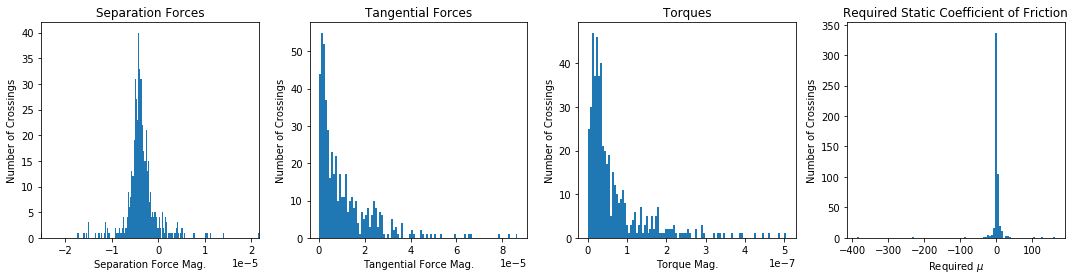

In [25]:
structure_view = get_structure_analysis_view(curved_linkage)
structure_view.show()

In [15]:
cfm = structural_analysis.weavingCrossingForceMagnitudes(curved_linkage, True)
if np.sum(cfm[:, 0]>0) > 0:
    print("Flipping crossing: ", np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):])
    for i in np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):]:
        curved_linkage.joint(i).type = get_opposite_joint_type(curved_linkage.joint(i).type)
    elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS)
    curved_linkage_view.update()

Flipping crossing:  [112 490 392 114 181 115 148 145 258 150 254 390 505  36 484 179 177 315
  69 314  66  62 417 339 463 158 155 397 468 210 348 286 212 213 214 153
 105 106 350 108 482 154 372]
0	0.00115541	0.304596	0.304596	1	1
1	0.000411555	1.04334	1.04334	1	1
2	0.000246141	0.147729	0.147729	1	1
3	0.000228808	0.0288741	0.0288741	1	1
4	0.000211401	0.0230569	0.0230569	1	1
5	0.000188788	0.0186022	0.0186022	1	1
6	0.00016179	0.0143549	0.0143549	1	0
7	9.70898e-05	0.14315	0.14315	1	1
8	5.47049e-05	0.0629998	0.0629998	1	1
9	4.82483e-05	0.036674	0.036674	1	1
10	4.36617e-05	0.00645515	0.00645515	1	1
11	4.05993e-05	0.0346376	0.0346376	1	1
12	3.9817e-05	0.111157	0.111157	1	1
13	3.79536e-05	0.0162478	0.0162478	1	1
14	3.77913e-05	0.000665678	0.000665678	1	0
15	3.26151e-05	0.0181014	0.0181014	1	1
16	3.21453e-05	0.000476745	0.000476745	0.5	0
17	3.19314e-05	0.00432875	0.00432875	1	1
18	3.18608e-05	0.000153856	0.000153856	1	0
19	3.16813e-05	0.0025517	0.0025517	1	0
20	3.16394e-05	0.000342788	0.000342

In [17]:
# second_structure_view = get_structure_analysis_view(curved_linkage)
# second_structure_view.show()

In [16]:
cfm = structural_analysis.weavingCrossingForceMagnitudes(curved_linkage, True)
if np.sum(cfm[:, 0]>0) > 0:
    print("Flipping crossing: ", np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):])
    for i in np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):]:
        curved_linkage.joint(i).type = get_opposite_joint_type(curved_linkage.joint(i).type)
    elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS)
    curved_linkage_view.update()

Flipping crossing:  [253  37 217 100 209 182 436  80 176 492 316 480]
0	0.000307201	0.147697	0.147697	1	1
1	9.32646e-05	0.22222	0.22222	1	1
2	7.06388e-05	0.105891	0.105891	1	1
3	6.17664e-05	0.0919522	0.0919522	1	1
4	5.499e-05	0.100398	0.100398	1	1
5	5.1048e-05	0.020615	0.020615	1	1
6	4.75821e-05	0.00267896	0.00267896	1	0
7	3.70021e-05	0.019574	0.019574	1	1
8	3.3293e-05	0.00114316	0.00114316	1	0
9	3.18983e-05	0.00164483	0.00164483	1	0
10	3.18364e-05	0.000703739	0.000703739	1	0
11	3.18282e-05	5.07333e-05	5.07333e-05	1	0
12	3.18282e-05	2.11117e-06	2.11117e-06	1	0
13	3.18282e-05	2.62362e-09	2.62362e-09	1	0


In [18]:
# third_structure_view = get_structure_analysis_view(curved_linkage)
# third_structure_view.show()

In [19]:
cfm = structural_analysis.weavingCrossingForceMagnitudes(curved_linkage, True)
if np.sum(cfm[:, 0]>0) > 0:
    print("Flipping crossing: ", np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):])
    for i in np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):]:
        curved_linkage.joint(i).type = get_opposite_joint_type(curved_linkage.joint(i).type)
    elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS)
    curved_linkage_view.update()

Flipping crossing:  [180 472 101 349]
0	0.000127639	0.0867842	0.0867842	0.5	1
1	0.000123604	0.282794	0.282794	1	1
2	6.32149e-05	0.0206963	0.0206963	1	1
3	5.51597e-05	0.0106225	0.0106225	1	1
4	4.90516e-05	0.0066543	0.0066543	1	1
5	4.41598e-05	0.0042361	0.0042361	1	0
6	4.12661e-05	0.0644203	0.0644203	1	1
7	3.41148e-05	0.00651791	0.00651791	0.125	0
8	3.40746e-05	0.00832364	0.00832364	1	1
9	3.3205e-05	0.000794393	0.000794393	1	0
10	3.21053e-05	0.00394348	0.00394348	1	1
11	3.19681e-05	0.000132084	0.000132084	0.5	0
12	3.18898e-05	0.000662032	0.000662032	1	0
13	3.18561e-05	0.000246606	0.000246606	1	0
14	3.18526e-05	6.52844e-05	6.52844e-05	1	0
15	3.18525e-05	7.85878e-06	7.85878e-06	1	0
16	3.18525e-05	9.28241e-08	9.28241e-08	1	0


Coefficient of Friction Percentiles 50, 75, 90:  1.7589037476355234 4.917468772221742 10.76527718157693


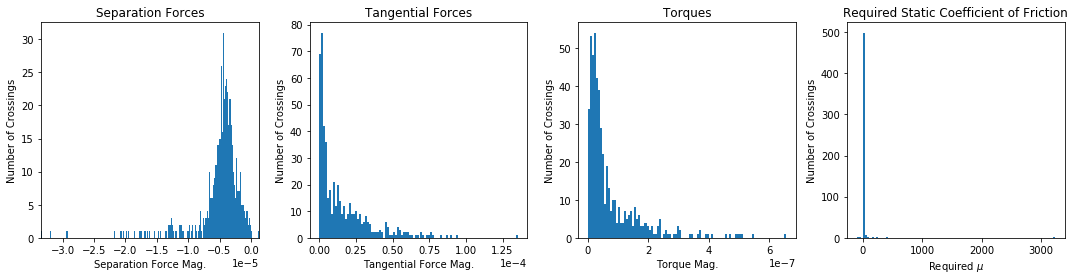

In [20]:
fourth_structure_view = get_structure_analysis_view(curved_linkage)
fourth_structure_view.show()

In [26]:
optimizer = initialize_stage_2_optimizer(curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, rw, sw, inner_gradTol = 1e-6)
optimizer.scaleJointWeights(0.1, 1000, [396, 412, 497])

In [27]:
optimizer.objective.terms[-1].term.weight = 5e6
{t.name: t.term.value() for t in optimizer.objective.terms}

{'ElasticEnergy': 0.9999999999999998,
 'TargetFitting': 0.11648874074872767,
 'RestLengthMinimization': 1.0,
 'RestCurvatureSmoothing': 0.010739390016527564,
 'ContactForce': 0.003427521826463745}

In [ ]:
optimizer, contact_opt_iterateData = contact_optimization(optimizer, curved_linkage, curved_linkage_view, minRestLen=-1, contact_weight = 5e6, normalWeight = 10, torqueWeight = 0, maxIter=2000, normalActivationThreshold=-5e-6)